# 패키지 및 FIFA_Tokenizer 호출 

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import os
import pickle as pkl
import shutil
from transformers import AutoTokenizer
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import pandas as pd
import copy
from tqdm.notebook import tqdm_notebook

In [ ]:
# 기본 저장 주소
ROOT_PATH ="./Topic_Modeling/"
# 데이터 저장 주소
DATA_FOLDER_PATH = os.path.join(ROOT_PATH,"1.Data/")


In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
tokenizer = AutoTokenizer.from_pretrained('fifa')

In [79]:
import pickle as pkl
with open(DATA_FOLDER_PATH +'fifa_data.pkl', 'rb') as f:
    train_ids=pkl.load(f)
    att_masks=pkl.load(f)
    df_fifa=pkl.load(f)
    token_pre=pkl.load(f)

In [80]:
train_ids=train_ids.long()
att_masks=att_masks.long()

In [81]:
train_ids[0]

tensor([    2, 31302, 34683, 30119, 30194, 30109,  9089, 11174, 11096,  9132,
        30057,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

### BERT random masking 수행

In [82]:
#### random masking
mask_count=[]
random_ids = []

empty_list=[]
full_list=[]
for i in tqdm_notebook(range(len(train_ids))):  
    input_id = copy.deepcopy(train_ids[i].numpy().reshape(1,128))
    mask_idx = []
    for j, i_id in enumerate(input_id[0]):
        if i_id.item() in(2,3,0):
            continue
        mask_idx.append(j)
    
    if len(mask_idx)==0:
        empty_list.append(i)
        continue


    if len(mask_idx) > 3:
        k = random.sample(mask_idx, round(len(mask_idx) * 0.15))
        k_masked=random.sample(k,round(len(k) * 0.8 ))
        input_id[0,k_masked] = 4                     
        random_ids.append(torch.from_numpy(input_id))
        full_list.append(i)


        
    elif len(mask_idx) <= 3:
        k_masked = random.sample(mask_idx,1)
        input_id[0,k_masked] = 4                     
        random_ids.append(torch.from_numpy(input_id))
        full_list.append(i)


    mask_count.append(len(k_masked))


  0%|          | 0/17232 [00:00<?, ?it/s]

In [83]:
len(full_list)

16987

In [84]:
len(empty_list)

245

In [85]:
train_labels=train_ids[full_list]

In [86]:
train_atts=att_masks[full_list]

In [87]:
random_ids=torch.cat(random_ids, dim=0)


In [88]:
len(random_ids)

16987

In [93]:
print(random_ids[0])
print(train_label[0])
print(train_att[0])

tensor([    2, 31302, 34683,     4, 30194,     4,  9089, 11174, 11096,  9132,
        30057,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

### train test 분할

In [91]:
train_ids, test_ids=train_test_split(random_ids, test_size=0.2,
                                                  random_state=3333)
train_att, test_att=train_test_split(train_atts, test_size=0.2,
                                                  random_state=3333)
train_label, test_label=train_test_split(train_labels, test_size=0.2,
                                                  random_state=3333)

In [92]:
# Print sentence 0, now as a list of IDs.
print('Token IDs:', train_ids[0])
print('label:',  train_label[0])
print('label:',  train_att[0])

Token IDs: tensor([    2, 30004, 10608,     4, 16832, 16397, 26740, 30914, 30004,  8485,
        12821,  9286,  8756,     4,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

In [94]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_ids, train_att, train_label)
val_dataset = TensorDataset(test_ids, test_att, test_label)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
#train_size = int(0.9 * len(dataset))
#val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

13,589 training samples
3,398 validation samples


In [95]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 26

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [96]:
##GPU 사용 시
device = torch.device(1)

In [113]:
model_version = 'beomi/kcbert-base'
#tokenizer = tokenization_kobert.KoBertTokenizer.from_pretrained(model_version)

In [114]:
from transformers import BertForMaskedLM, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

model = BertForMaskedLM.from_pretrained(model_version, # Use the 12-layer BERT model, with an uncased vocab.
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.    
)

#model = BertForMaskedLM.from_pretrained("bert-base-uncased",config = config)


model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
model.cuda(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50826, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [99]:
!nvidia-smi

Sun Sep 12 07:10:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 426.00       Driver Version: 426.00       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  TCC  | 00000000:00:05.0 Off |                    0 |
| N/A   30C    P0    37W / 300W |    370MiB / 32642MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  TCC  | 00000000:00:06.0 Off |                    0 |
| N/A   35C    P0    53W / 300W |  11341MiB / 32642MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
        

In [100]:
torch.cuda.is_available()

True

In [101]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 204 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (50826, 768)
bert.embeddings.position_embeddings.weight                (300, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [102]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [103]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 20


# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [104]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [105]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# attention weight saving
## attention_train = []
## attention_valid = []

# input_id saving
## input_id_train = []
## input_id_valid = []

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

out_dir = './fifa_bert/'
output_dir = out_dir + 'random_all'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [106]:
def save_models(out_dir):
    
    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

    output_dir = out_dir

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Good practice: save your training arguments together with the trained model
    # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

### 모델 학습 수행

In [107]:
import pickle
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits, attention_t = model(b_input_ids, 
                                         token_type_ids=None, 
                                         attention_mask=b_input_mask,
                                         masked_lm_labels=b_labels)
        #print('train_loss:', loss)
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for step, batch in enumerate(validation_dataloader):
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss, logits, attention_v = model(b_input_ids, 
                                                token_type_ids=None, 
                                                attention_mask=b_input_mask,
                                                masked_lm_labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        #torch.argmax(logits[0][0, 2]).item()
        
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
       
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    if epoch_i > 0 and avg_val_loss < training_stats[epoch_i-1]['Valid. Loss']:
        epoch_dir = out_dir + 'random_all_epoch_' + str(epoch_i+1) + '/'
        save_models(epoch_dir)
        
        epoch_output = epoch_dir + 'random_all_weight/'      
        shutil.copytree(output_dir,epoch_output)
    
    

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    523.    Elapsed: 0:00:11.
  Batch    80  of    523.    Elapsed: 0:00:22.
  Batch   120  of    523.    Elapsed: 0:00:33.
  Batch   160  of    523.    Elapsed: 0:00:44.
  Batch   200  of    523.    Elapsed: 0:00:55.
  Batch   240  of    523.    Elapsed: 0:01:06.
  Batch   280  of    523.    Elapsed: 0:01:17.
  Batch   320  of    523.    Elapsed: 0:01:28.
  Batch   360  of    523.    Elapsed: 0:01:40.
  Batch   400  of    523.    Elapsed: 0:01:51.
  Batch   440  of    523.    Elapsed: 0:02:02.
  Batch   480  of    523.    Elapsed: 0:02:13.
  Batch   520  of    523.    Elapsed: 0:02:24.

  Average training loss: 0.20287
  Training epcoh took: 0:02:25

Running Validation...
  Validation Loss: 0.12711
  Validation took: 0:00:11

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    523.    Elapsed: 0:00:11.
  Batch    80  of    523.    Elapsed: 0:00:22.
  Batch   120  of    523.    Elapsed: 0:00:33.
  Batch   160  of 

In [108]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.

#df_stats.to_excel('/content/drive/MyDrive/R&D_health/base/base_test_cls_v3.xlsx')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.2029,0.1271,0:02:25,0:00:11
2,0.1137,0.1255,0:02:25,0:00:11
3,0.1004,0.1285,0:02:24,0:00:11
4,0.0838,0.1335,0:02:25,0:00:11
5,0.0671,0.1362,0:02:25,0:00:11
6,0.0531,0.1387,0:02:25,0:00:11
7,0.0420,0.1406,0:02:25,0:00:11
8,0.0329,0.1425,0:02:25,0:00:11
9,0.0261,0.1442,0:02:25,0:00:11


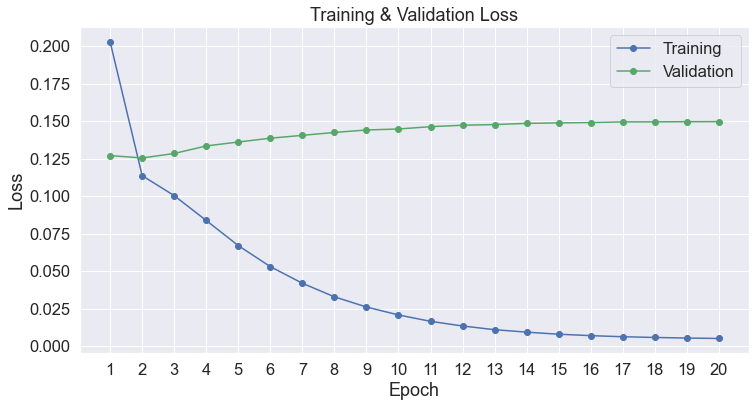

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()